In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes


In [50]:
user='S'

if user=='S':
    mandat_dep=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/liste_mandat.csv")#on récupère le csv de la liste des mandats
    df_depu=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/listeDepute_complete.csv")

if user=='G':
    mandat_dep=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/liste_mandatdef.csv") 
    df_depu=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/listeDepute_complete.csv")


Extraction des dates de début de mandat

In [51]:
debut_mandat=[]
for dates in mandat_dep["Mandat"]:
    dates=str(dates).split()
    debut_mandat.append(' '.join(dates[1:4]))
    
mandat_dep["Debut Mandat"]=np.array(debut_mandat)
mandat_dep.head()

,Unnamed: 0,Département,Groupe,Législature,Mandat,Régime politique,Nom,Debut Mandat
0,0,Territoire-de-Belfort,Union pour la majorité présidentielle,XIIe législature,Du 19 juin 2002 au 19 juin 2007,Cinquième République - Assemblée nationale,Damien Meslot,19 juin 2002
1,0,Territoire-de-Belfort,Union pour un mouvement populaire,XIIIe législature,Du 20 juin 2007 au 19 juin 2012,Cinquième République - Assemblée nationale,Damien Meslot,20 juin 2007
2,0,Territoire-de-Belfort,Union pour un mouvement populaire,XIVe législature,Du 20 juin 2012 au 20 juin 2017,Cinquième République - Assemblée nationale,Damien Meslot,20 juin 2012
3,0,Ille-et-Vilaine,La République en Marche,XVe législature (Législature en cours),Depuis le 21 juin 2017 (mandat en cours),Cinquième République - Assemblée nationale,Christine Cloarec-Le Nabour,le 21 juin
4,0,Ardèche,Socialiste,XIe législature,Du 1er juin 1997 au 18 juin 2002,Cinquième République - Assemblée nationale,Pascal Terrasse,1er juin 1997


<b> TRANSTYPAGE !!! (Je suis heureux que ça ait marché) 

In [52]:
df_depu[["Nom","Né le"]].head(2)
mandat_dep[["Nom","Debut Mandat"]].head(2)
age_dep=mandat_dep.set_index('Nom').join(df_depu[["Nom","Né le"]].set_index('Nom'), on='Nom')
mandat_dep.reset_index()
mois={'janvier':1,'février':2, 'mars':3, 'avril':4, 'mai':5, 'juin':6, 'juillet':7, 'août':8, 'septembre':9, 'octobre':10, 'novembre':11, 'décembre':12}
def transtype_date(x):
    x=str(x)        
    date_texte=x.split() 
    if len(date_texte)>1 :
        if  date_texte[1] in (mois.keys()):
            if date_texte[0]=="1er":
                date_texte[0]='1'
            date_texte[1]=str(mois[date_texte[1]])
            date_nombre='/'.join(date_texte)
            return pd.to_datetime(date_nombre)
    else:
        return pd.NaT


age_dep["Date de naissance"]=age_dep["Né le"].apply(lambda x: transtype_date(x))
age_dep["Date debut mandat"]=age_dep["Debut Mandat"].apply(lambda x: transtype_date(x))
age_dep.head(2)

,Unnamed: 0,Département,Groupe,Législature,Mandat,Régime politique,Debut Mandat,Né le,Date de naissance,Date debut mandat
Nom,,,,,,,,,,
Damien Meslot,0,Territoire-de-Belfort,Union pour la majorité présidentielle,XIIe législature,Du 19 juin 2002 au 19 juin 2007,Cinquième République - Assemblée nationale,19 juin 2002,11 novembre 1964,1964-11-11,2002-06-19
Damien Meslot,0,Territoire-de-Belfort,Union pour un mouvement populaire,XIIIe législature,Du 20 juin 2007 au 19 juin 2012,Cinquième République - Assemblée nationale,20 juin 2007,11 novembre 1964,1964-11-11,2007-06-20


In [53]:
age_dep['age depute']=age_dep['Date debut mandat']-age_dep['Date de naissance']#on crée la variable age au debut du mandat, en jour
age_dep['age en année']=age_dep['age depute'].apply(lambda x: float(x.days / 365.25))#et on la transforme en années
age_dep=age_dep[['Département','Groupe', 'Législature', 'Mandat', 'Régime politique', 'age en année','Date debut mandat']]

In [54]:
mandat_dep.count()#on vérifie qu'il n'y a pas trop de manques

Unnamed: 0          36128
Département         35931
Groupe              32005
Législature         36128
Mandat              36128
Régime politique    36126
Nom                 36128
Debut Mandat        36128
dtype: int64

In [55]:
dep_possible=list(mandat_dep['Département'].unique())#une liste de tous les départements
dep_possible.remove(" Département d'élection inconnu")
dep_possible.remove(np.nan)

Construction d'un tableau des caractérstiques des départements

In [56]:
df=age_dep.reset_index()
w,x,y,z=[],[],[],[]
for dep in dep_possible :
    w+=[df[df['Département']==dep]['age en année'].mean()]#on prend la moyenne d'age dans le département
    x+=[len(df[df['Département']==dep])]#on compte le nombre total de mandat dans le département
    y+=[len(df[df['Département']==dep]['Nom'].unique())]#Puis le nombre de députés différent par dpt
    z+=[x[-1]/y[-1]] #Ceci est le nombre moyen de mandat par député
    
carac_dep_bis=np.array([w, x, y, z])#on crée un dataframe avec les informations
table_depmt = pd.DataFrame(carac_dep_bis, index=['age moyen des deputes', 'nombre_mandat', 'nombre député','nombre moyen de mandats par député'],columns=dep_possible)
table_depmt.head()


,Territoire-de-Belfort,Ille-et-Vilaine,Ardèche,Hauts-de-Seine,La Réunion,Puy-de-Dôme,Essonne,Haut-Rhin,Haute-Marne,Hautes-Pyrénées,...,Départements de l'Empire français aujourd'hui en Belgique,Mont-Blanc,Départements de l'Empire français aujourd'hui aux Pays-Bas,Départements de l'Empire français aujourd'hui en Allemagne,Saint-Domingue,Etranger,Départements de l'Empire français aujourd'hui en Suisse,Rhône-et-Loire,Départements de l'Empire français aujourd'hui au Luxembourg,Ile-de-France (Maurice)
age moyen des deputes,46.976129,47.333331,52.584768,54.076791,47.356341,49.266955,47.782325,49.510650,49.614406,47.610409,...,44.775862,43.130094,48.834702,51.882537,35.140657,38.944559,44.386286,36.502179,49.342574,38.561259
nombre_mandat,64.000000,572.000000,331.000000,184.000000,139.000000,475.000000,92.000000,325.000000,208.000000,251.000000,...,98.000000,48.000000,27.000000,31.000000,20.000000,2.000000,11.000000,20.000000,8.000000,2.000000
nombre député,27.000000,216.000000,132.000000,67.000000,50.000000,209.000000,38.000000,157.000000,94.000000,103.000000,...,83.000000,34.000000,26.000000,31.000000,15.000000,2.000000,10.000000,17.000000,7.000000,2.000000
nombre moyen de mandats par député,2.370370,2.648148,2.507576,2.746269,2.780000,2.272727,2.421053,2.070064,2.212766,2.436893,...,1.180723,1.411765,1.038462,1.000000,1.333333,1.000000,1.100000,1.176471,1.142857,1.000000


In [57]:
print(min(table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]))
print(max(table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]))
print((table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40]).mean())
print((table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre moyen de mandats par député']<2][table_depmt.loc['nombre député']>40]).count())

1.0
3.09375
2.290677795052528
5


In [58]:
table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre moyen de mandats par député']<2][table_depmt.loc['nombre député']>40]

 Allier                                                       1.974843
 Anciens départements d'Algérie                               1.526570
 Meurthe                                                      1.986486
 Départements de l'Empire français aujourd'hui en Italie      1.000000
 Départements de l'Empire français aujourd'hui en Belgique    1.180723
Name: nombre moyen de mandats par député, dtype: float64

Les valeurs les plus basses sont constituées par des départements qui ont appartenu peu de temps à la France, et où les occasions de se faire réélire ont donc été peu nombreuses.

In [59]:
table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre moyen de mandats par député']>2.5][table_depmt.loc['nombre député']>40]

 Ille-et-Vilaine       2.648148
 Ardèche               2.507576
 Hauts-de-Seine        2.746269
 La Réunion            2.780000
 Alpes-Maritimes       2.570000
 Oise                  2.611111
 Meurthe-et-Moselle    2.567308
 Charente-Maritime     2.533333
 Indre-et-Loire        2.511450
 Landes                2.548077
 Manche                2.627119
 Seine-St-Denis        2.622642
 Loire-Atlantique      2.589286
 Orne                  2.510949
 Val-de-Marne          2.770833
 Savoie                3.093750
 Haute-Savoie          2.827586
 Tarn-et-Garonne       2.523810
Name: nombre moyen de mandats par député, dtype: float64

Au contraire, les départements où il y a le plus de réélections ne semblent pas avoir de problèmes de ce type.

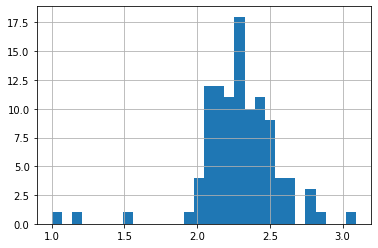

In [60]:
table_depmt.loc['nombre moyen de mandats par député'][table_depmt.loc['nombre député']>40].hist(bins=30)

Construction des cartes de ces caractéristiques

In [61]:
#récupération d'une carte des départements français
import requests
import tempfile
import zipfile


In [62]:
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname =temporary_location, destname = "borders"):#fonction qui dézippe
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref: 
        zip_ref.extractall(dirname + '/' + destname)
download_unzip('https://www.data.gouv.fr/fr/datasets/r/3096e551-c68d-40ce-8972-a228c94c0ad1')#l'URL où on trouve les départements

In [63]:
carte_departement = gpd.read_file(tempfile.gettempdir() + "/borders/departements-20140306-100m.dbf")#on va chercher le fichier là où on l'a stocké
carte_metrop = carte_departement.loc[0:95]#on enlève les départements d'outre-mer pour avoir une carte lisible


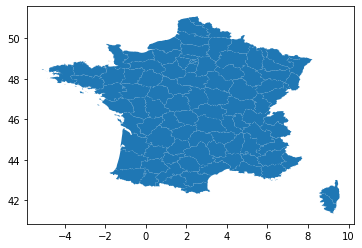

In [64]:
carte_metrop.plot()

In [65]:
table_depmt.columns=[i[1:] for i in table_depmt.columns]#on enlève l'espace devant le nom des départements

In [66]:
carte_metrop.set_index('nom', inplace=True)#on met le nom du département en index pour pouvoir joindre les bases

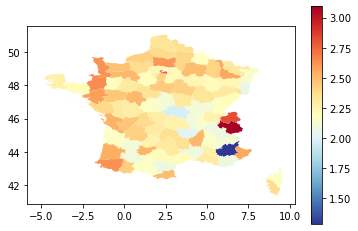

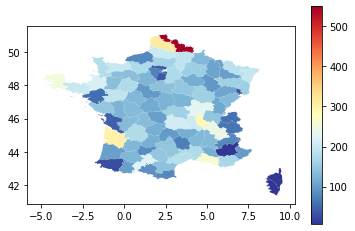

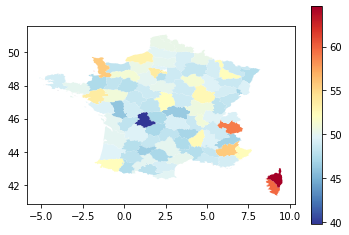

In [67]:
df = carte_metrop.merge(table_depmt.T, how = 'inner', left_index=True, right_index=True)#on transpose table pour avoir les départements en noms de lignes
df.plot(column = 'nombre moyen de mandats par député', cmap = 'RdYlBu_r', legend=True)#on crée des cartes
df.plot(column='nombre député', cmap = 'RdYlBu_r', legend=True)
df.plot(column='age moyen des deputes', cmap='RdYlBu_r', legend=True)

In [68]:
table_depmt.T.head()

,age moyen des deputes,nombre_mandat,nombre député,nombre moyen de mandats par député
Territoire-de-Belfort,46.976129,64.0,27.0,2.370370
Ille-et-Vilaine,47.333331,572.0,216.0,2.648148
Ardèche,52.584768,331.0,132.0,2.507576
Hauts-de-Seine,54.076791,184.0,67.0,2.746269
La Réunion,47.356341,139.0,50.0,2.780000


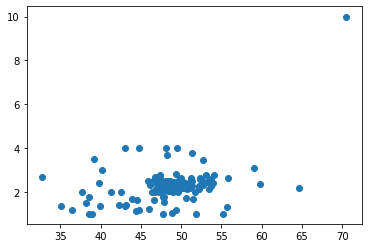

In [69]:
#C'était juste pour voir ^^
bubu=table_depmt.T.reset_index()[["age moyen des deputes","nombre moyen de mandats par député"]]
plt.scatter(bubu["age moyen des deputes"],bubu["nombre moyen de mandats par député"])

On s'occupe des régimes maintenant

In [70]:
import urllib#pour récupérer les données
import bs4#pour rendre lisibles les données
import re
def Scrap (url):
    req = urllib.request.Request(url)
    html = urllib.request.urlopen(req).read()
    page = bs4.BeautifulSoup(html, "lxml")
    return page
def ToDf (table) :
    Listgrossiere=pd.read_html(str(table))#on transforme le tableau en liste de dataframes
    listeDf=Listgrossiere[0]#on récupère le dataframe
    return listeDf
page=Scrap('https://fr.wikipedia.org/wiki/Liste_des_r%C3%A9gimes_fran%C3%A7ais')
table = page.find('table')#on récupère le seul tableau de la page qui liste des députés
listeReg=ToDf(table)

In [71]:
listeReg

Nom  \
                                                  Nom   
0                                Monarchie fédérative   
1                                   Monarchie féodale   
2                                   Monarchie absolue   
3                                   Monarchie absolue   
4                         Monarchie constitutionnelle   
5                         Monarchie constitutionnelle   
6                                 Première République   
7                                 Première République   
8                                 Première République   
9                                 Première République   
10                                Première République   
11                                Première République   
12  Commission consulaire du 11 novembre 1799 au 1...   
13        Consulat du 13 décembre 1799 au 2 août 1802   
14       Premier consul du 2 août 1802 au 18 mai 1804   
15                          Autoritarisme (1802–1804)   
16                                     Premier Empire   
17                              Première Restauration   
18                                         Cent-Jours   
19                               Seconde Restauration   
20                               Monarchie de Juillet   
21                                Deuxième République   
22                                Deuxième République   
23                                      Second Empire   
24                               Troisième République   
25                               Troisième République   
26       Assemblée nationale sous la IIIe (1875-1942)   
27                    Chambre des députés (1875-1942)   
28               France libre puis France Combattante   
29         Comité français de la Libération nationale   
30  Gouvernement provisoire de la République franç...   
31  Gouvernement provisoire de la République franç...   
32                               Quatrième République   
33                               Cinquième République   
34                              Congrès (1958–actuel)   
35       Assemblée nationale sous la Ve (1958–actuel)   

                                            Date  \
                                            Date   
0                   de 481[1] au 1er juin 987[2]   
1              du 1er juin 987 au 14 mai 1610[3]   
2         du 14 mai 1610 au 14 septembre 1791[4]   
3         du 14 mai 1610 au 14 septembre 1791[4]   
4      du 14 septembre 1791 au 21 septembre 1792   
5      du 14 septembre 1791 au 21 septembre 1792   
6            du 21 septembre 1792 au 18 mai 1804   
7            du 21 septembre 1792 au 18 mai 1804   
8            du 21 septembre 1792 au 18 mai 1804   
9            du 21 septembre 1792 au 18 mai 1804   
10           du 21 septembre 1792 au 18 mai 1804   
11           du 21 septembre 1792 au 18 mai 1804   
12                  Corps législatif (1799–1814)   
13                                           NaN   
14                                           NaN   
15                          Constitution de 1802   
16                du 18 mai 1804 au 4 avril 1814   
17               du 6 avril 1814 au 20 mars 1815   
18             du 20 mars 1815 au 7 juillet 1815   
19              du 8 juillet 1815 au 2 août 1830   
20             du 9 août 1830 au 24 février 1848   
21         du 24 février 1848 au 2 décembre 1852   
22         du 24 février 1848 au 2 décembre 1852   
23        du 2 décembre 1852 au 4 septembre 1870   
24        du 4 septembre 1870 au 10 juillet 1940   
25        du 4 septembre 1870 au 10 juillet 1940   
26  Assemblée nationale sous la IIIe (1875-1942)   
27                             Sénat (1875-1942)   
28                du 18 juin 1940 au 3 juin 1943   
29                 du 3 juin 1943 au 3 juin 1944   
30             du 3 juin 1944 au 27 octobre 1946   
31             du 3 juin 1944 au 27 octobre 1946   
32          du 27 octobre 1946 au 4 octobre 1958   
33                    du 4 octobre 1958 à actuel   
34         

In [72]:
listeReg2=pd.DataFrame(np.array([listeReg[('Nom','Nom')],listeReg[('Date','Date')]]).T,columns=["Nom","Date"])
lstRegime=listeReg2[16:]#on enlève les lignes correspondants aux régimes trop anciens

In [73]:
debut_regime=[]
import datetime#on importe la date du jour
maintenant=pd.to_datetime(str(datetime.datetime.now().year)+'/'+str(datetime.datetime.now().month)+'/'+str(datetime.datetime.now().day))
def extraire_date_1(x, Debut=True):
    dates=str(x)
    dates=str(dates).split()
    if Debut:
        dates=' '.join(dates[1:4])
    else:
        dates=' '.join(dates[5:])
    return transtype_date(dates)
    
    
lstRegime['Date2']=lstRegime['Date'].apply(lambda x : extraire_date_1(x))
lstRegime['Date3']=lstRegime['Date'].apply(lambda x : extraire_date_1(x,Debut=False))
lstRegime['Date3'][lstRegime['Nom']=='Cinquième République']=maintenant
lstRegime['Durée']=lstRegime['Date3']-lstRegime['Date2']
lstRegime['Durée en année']=lstRegime['Durée'].apply(lambda x: float(x.days / 365.25))

C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [74]:
lstRegime=lstRegime[~lstRegime["Date2"].isna()].drop_duplicates()
lstRegime=lstRegime.reset_index().drop(['index'], axis=1)
lstRegime=lstRegime.set_index('Date2', drop=False)

In [75]:
lstRegime

,Nom,Date,Date2,Date3,Durée,Durée en année
Date2,,,,,,
1804-05-18,Premier Empire,du 18 mai 1804 au 4 avril 1814,1804-05-18,1814-04-04,3608 days,9.878166
1814-06-04,Première Restauration,du 6 avril 1814 au 20 mars 1815,1814-06-04,1815-03-20,289 days,0.791239
1815-03-20,Cent-Jours,du 20 mars 1815 au 7 juillet 1815,1815-03-20,1815-07-07,109 days,0.298426
1815-08-07,Seconde Restauration,du 8 juillet 1815 au 2 août 1830,1815-08-07,1830-02-08,5299 days,14.507871
1830-09-08,Monarchie de Juillet,du 9 août 1830 au 24 février 1848,1830-09-08,1848-02-24,6378 days,17.462012
1848-02-24,Deuxième République,du 24 février 1848 au 2 décembre 1852,1848-02-24,1852-02-12,1449 days,3.967146
1852-02-12,Second Empire,du 2 décembre 1852 au 4 septembre 1870,1852-02-12,1870-04-09,6631 days,18.154689
1870-04-09,Troisième République,du 4 septembre 1870 au 10 juillet 1940,1870-04-09,1940-10-07,25748 days,70.494182
1940-06-18,France libre puis France Combattante,du 18 juin 1940 au 3 juin 1943,1940-06-18,1943-03-06,991 days,2.713210


In [76]:
Regime_depute=age_dep.reset_index()
Regime_depute=Regime_depute[Regime_depute["Date debut mandat"] >= lstRegime["Date2"][0]]
print(Regime_depute["Date debut mandat"][1]>lstRegime['Date2'][0])#on vérifie que les dates de fin sont supérieures à celles de début

True


In [77]:
def TrouverRegime(x):
    lstRegime['Date2'][0]
    regime=lstRegime['Nom'][0]
    i=0    
    while (not (x<lstRegime['Date3'][i])) and i<=11:# lstRegime['Date2'][i]<=cela pose des problèmes pour des gens comme Lambert Rivière qui sont nés durant des interrègnes selon Wikipedia(1814-04-06)
        i+=1
        regime=lstRegime['Nom'][i]
    return regime

In [78]:
Regime_depute["Régime"]=Regime_depute["Date debut mandat"].apply(lambda x : TrouverRegime(x) )

In [79]:
Regime_depute.sample(10)

,Nom,Département,Groupe,Législature,Mandat,Régime politique,age en année,Date debut mandat,Régime
12688,"Pierre, Cyprien Mathé",Côte-d'Or,Agraire indépendant,XVIe législature,Du 3 mai 1936 au 31 mai 1942&amp;ast;,Troisième République - Chambre des députés,54.151951,1936-03-05,Troisième République
4921,"Roland, Eugène Leroy",Seine-Maritime,Communiste,IIIe législature,Du 3 avril 1967 au 30 mai 1968,Cinquième République - Assemblée nationale,40.911704,1967-03-04,Cinquième République
13475,Pascal Ceccaldi,Aisne,Gauche radicale-socialiste,IXe législature,Du 20 mai 1906 au 31 mai 1910,Troisième République - Chambre des députés,29.396304,1906-05-20,Troisième République
6531,Ahmed Mohamed,Comores,Union pour la nouvelle République-UDT,IIe législature,Du 18 novembre 1962 au 2 avril 1967,Cinquième République - Assemblée nationale,45.776865,1962-11-18,Cinquième République
1809,Raymond Couderc,Hérault,Union pour la démocratie française et du centre,Xe législature,Du 2 avril 1993 au 21 avril 1997,Cinquième République - Assemblée nationale,46.387406,1993-02-04,Cinquième République
17748,Julien Simyan,Saône-et-Loire,Parti radical et radical socialiste,XIIe législature,Du 16 novembre 1919 au 8 juillet 1921,Troisième République - Chambre des députés,69.585216,1919-11-16,Troisième République
4880,Jacques Chaminade,Corrèze,Communiste,VIe législature,Du 19 mars 1978 au 22 mai 1981,Cinquième République - Assemblée nationale,51.586585,1978-03-19,Cinquième République
22159,Jules Deregnaucourt,Nord,Union républicaine,,Du 7 janvier 1872 au 24 février 1872,Assemblée Nationale,51.093771,1872-07-01,Troisième République
14069,"Jules, Paul Aubriot",Seine,Républicain socialiste et socialiste français,XIIIe législature,Du 11 mai 1924 au 31 mai 1928,Troisième République - Chambre des députés,51.266256,1924-11-05,Troisième République
6428,"Jacques, Robert Baumel",Hauts-de-Seine,Union des démocrates pour la République,IVe législature,Du 11 juillet 1968 au 22 juillet 1969,Cinquième République - Assemblée nationale,50.431211,1968-11-07,Cinquième République


In [80]:
print(Regime_depute["Régime politique"].unique())
print(Regime_depute["Régime"].unique())

['Cinquième République - Assemblée nationale'
 'Quatrième République - Assemblée nationale'
 'Gouvernement provisoire de la République française'
 'Troisième République - Chambre des députés' 'Assemblée Nationale'
 'Second Empire - Corps législatif' 'Deuxième République'
 'Monarchie de Juillet - Chambre des députés'
 'Seconde Restauration - Chambre des députés des départements'
 'Cent-Jours' 'Consulat et Premier Empire' 'Première Restauration']
['Cinquième République' 'Quatrième République'
 'Gouvernement provisoire de la République française'
 'Troisième République' 'Second Empire' 'Deuxième République'
 'Monarchie de Juillet' 'Seconde Restauration' 'Cent-Jours'
 'Premier Empire' 'Première Restauration']


In [81]:
reg_possible=list(Regime_depute['Régime'].unique())#une liste de tous les régimes
df=Regime_depute.reset_index()
v,w,x,y,z,a,b,c,d=[],[],[],[],[],[],[],[],[]
for reg in reg_possible :
    v+=[float(lstRegime[lstRegime['Nom']==reg]['Durée en année'])]#la durée du régime
    w+=[df[df['Régime']==reg]['age en année'].mean()]#on prend la moyenne d'age dans ce régime
    x+=[len(df[df['Régime']==reg])]#on compte le nombre total de mandat dans le régime
    y+=[len(df[df['Régime']==reg]['Nom'].unique())]#Puis le nombre de députés différent
    z+=[x[-1]/y[-1]] #Ceci est le nombre moyen de mandat par député
    a+=[x[-1]/v[-1]]#le nombre moyen de mandat par an
    b+=[len(Regime_depute[Regime_depute['Régime']==reg]['Législature'].unique())]
    c+=[x[-1]/b[-1]]#nombre moyen de mandats par législature
    d+=[v[-1]/b[-1]]#durée moyenne d'une législature
    
carac_reg_bis=np.array([v, w, x, y, z, a, b, c, d])#on crée un dataframe avec les informations
table_reg = pd.DataFrame(carac_reg_bis, index=['durée du régime', 'age moyen des deputes', 'nombre_mandat', 'nombre député','nombre moyen de mandats par député', 'nombre moyen de mandats par an', 'nombre de législature', 'nombre moyen de mandats par législature', 'durée moyenne de législature'],columns=reg_possible).T
table_reg



,durée du régime,age moyen des deputes,nombre_mandat,nombre député,nombre moyen de mandats par député,nombre moyen de mandats par an,nombre de législature,nombre moyen de mandats par législature,durée moyenne de législature
Cinquième République,62.603696,53.299084,8097.0,3199.0,2.531103,129.337411,15.0,539.800000,4.173580
Quatrième République,11.452430,48.876792,1385.0,931.0,1.487648,120.935035,5.0,277.000000,2.290486
Gouvernement provisoire de la République française,2.642026,45.263814,1841.0,842.0,2.186461,696.813731,3.0,613.666667,0.880675
Troisième République,70.494182,49.349630,11513.0,4893.0,2.352953,163.318442,17.0,677.235294,4.146717
Second Empire,18.154689,51.336521,1296.0,608.0,2.131579,71.386518,4.0,324.000000,4.538672
Deuxième République,3.967146,45.702348,1796.0,1349.0,1.331357,452.718427,2.0,898.000000,1.983573
Monarchie de Juillet,17.462012,49.384249,3750.0,1462.0,2.564979,214.751881,7.0,535.714286,2.494573
Seconde Restauration,14.507871,52.205648,2562.0,1417.0,1.808045,176.593791,5.0,512.400000,2.901574
Cent-Jours,0.298426,47.485411,325.0,314.0,1.035032,1089.048165,1.0,325.000000,0.298426
Premier Empire,9.878166,46.797498,468.0,447.0,1.046980,47.377217,2.0,234.000000,4.939083


In [82]:
table_longreg=table_reg[table_reg['durée du régime']>10]

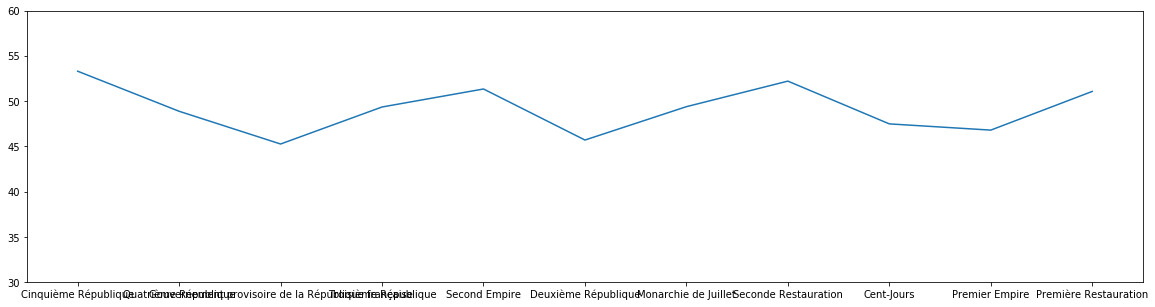

In [83]:
plt.figure(figsize=(20,5))
plt.ylim(bottom=30, top=60)
plt.plot(table_reg["age moyen des deputes"])

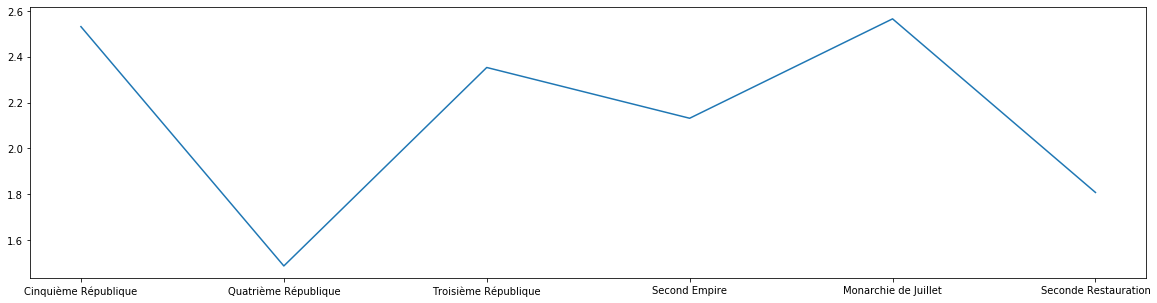

In [84]:
plt.figure(figsize=(20,5))
plt.plot(table_longreg["nombre moyen de mandats par député"])

 
 
 ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
 
 Departement de Naissance, début des stat 
 
 ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo






In [85]:
df_depu["Département de naissance"].count()

15974

In [86]:
df_depu[df_depu["Département de naissance"].isna()].count()
#On va voir si nos données ne sont pas trop biaisée

Unnamed: 0                  22
Nom                         22
Né le                       22
Département de naissance     0
Département de mort         22
dtype: int64

In [87]:
dept_naiss=Regime_depute.set_index('Nom').join(df_depu[["Nom","Né le", "Département de naissance"]].set_index('Nom'), on='Nom')
dept_naiss=dept_naiss.reset_index()
dept_naiss.head()


,Nom,Département,Groupe,Législature,Mandat,Régime politique,age en année,Date debut mandat,Régime,Né le,Département de naissance
0,Damien Meslot,Territoire-de-Belfort,Union pour la majorité présidentielle,XIIe législature,Du 19 juin 2002 au 19 juin 2007,Cinquième République - Assemblée nationale,37.601643,2002-06-19,Cinquième République,11 novembre 1964,Inconnu
1,Damien Meslot,Territoire-de-Belfort,Union pour un mouvement populaire,XIIIe législature,Du 20 juin 2007 au 19 juin 2012,Cinquième République - Assemblée nationale,42.603696,2007-06-20,Cinquième République,11 novembre 1964,Inconnu
2,Damien Meslot,Territoire-de-Belfort,Union pour un mouvement populaire,XIVe législature,Du 20 juin 2012 au 20 juin 2017,Cinquième République - Assemblée nationale,47.605749,2012-06-20,Cinquième République,11 novembre 1964,Inconnu
3,Pascal Terrasse,Ardèche,Socialiste,XIe législature,Du 1er juin 1997 au 18 juin 2002,Cinquième République - Assemblée nationale,32.197125,1997-01-06,Cinquième République,26 octobre 1964,Gard
4,Pascal Terrasse,Ardèche,Socialiste,XIIe législature,Du 19 juin 2002 au 19 juin 2007,Cinquième République - Assemblée nationale,37.645448,2002-06-19,Cinquième République,26 octobre 1964,Gard


In [88]:
dept_naiss[dept_naiss["Département de naissance"]=="Inconnu"].groupby("Régime").count()['Département de naissance'] / dept_naiss.groupby("Régime").count()['Département de naissance']*100
#En gros, il y a entre 10 et 20% de departement de naissance manquant par régime

Régime
Cent-Jours                                            11.002445
Cinquième République                                  18.358002
Deuxième République                                    6.878307
Gouvernement provisoire de la République française    11.649155
Monarchie de Juillet                                   6.468798
Premier Empire                                        29.522184
Première Restauration                                 10.928962
Quatrième République                                  12.861538
Second Empire                                          9.313725
Seconde Restauration                                  10.434783
Troisième République                                   8.253773
Name: Département de naissance, dtype: float64

Les départements où on a le plus de valeurs manquante sont aussi ceux où il y a le plus de député : l'analyse des valeurs manquantes est a affiné mais nous pensons qu'utiliser ces variables reste possible.

In [90]:
listeLegis=['Ire','IIe', 'IIIe', 'IVe', 'Ve', 'VIe', 'VIIe', 'VIIIe', 'IXe', 'Xe', 'XIe', 'XIIe', 'XIIIe', 'XIVe', 'XVe', 'XVIe']
listeLegislature=[' '+i+' législature ' for i in listeLegis]#on crée une liste des législatures dans le bon ordre

In [91]:
#on va s'intéresser aux législatures des républiques qui ont duré longtemps
dept_naiss_3=dept_naiss[dept_naiss['Régime'] =='Troisième République']
dept_naiss_5=dept_naiss[dept_naiss['Régime'] =='Cinquième République']
dept_naiss_emp2=dept_naiss[dept_naiss['Régime'] =='Second Empire']
diffdep_3=[]#le nombre de députés dans la base pour les législatures i et i+1 pour la Troisième République
diffdep_5=[]#pour la Cinquième
diffdep_emp2=[]#pour le second Empire
[tauxreelec_3,tauxreelec_5, tauxreelec_emp2]=[[],[],[]]#le taux de réelection entre les législatures i et i+1 pour la troisième République
[date_leg_3, date_leg_5,date_leg_emp2]=[[],[],[]]#les dates de début de législatures


def data_legis(compteur, dept_naissance, diffdep, tauxreelec, date_leg):
    passation=pd.concat((dept_naissance[dept_naissance['Législature'] ==listeLegislature[compteur]],dept_naissance[dept_naissance['Législature']==listeLegislature[compteur+1]]))

    if not dept_naissance[dept_naissance['Législature']==listeLegislature[compteur+1]]['Date debut mandat'].empty :#s'il y a deux législatures à comparer :
        nbredep=passation['Nom'].count()
        diffdep+=[nbredep]
        tauxreelec+=[passation['Nom'].unique().shape[0]/nbredep]
        date_leg+=[min(passation.tail(1)['Date debut mandat']).year]
    return diffdep, tauxreelec, date_leg
            
for compteur in range(len(listeLegislature)-1) :
    data_legis(compteur, dept_naiss_3, diffdep_3, tauxreelec_3, date_leg_3)
    data_legis(compteur, dept_naiss_5, diffdep_5, tauxreelec_5, date_leg_5)
    data_legis(compteur, dept_naiss_emp2, diffdep_emp2, tauxreelec_emp2, date_leg_emp2)

print(diffdep_5)#on a une bonne base jusqu'à la douzième législature pour la 5e République, avec une grande majorité des députés présents dans la base       

[1411, 1520, 1461, 1498, 1627, 1641, 1576, 1570, 1651, 1541, 1400, 1400, 1431, 1528, 1514]
[1470, 1492, 1573, 1555, 1406, 1353, 1411, 1470, 1531, 1426, 1316, 1111, 674, 241]
[0.5279943302622254, 0.5901315789473685, 0.6632443531827515, 0.6789052069425902, 0.5863552550706822, 0.570993296770262, 0.565989847715736, 0.5643312101910828, 0.5608721986674743, 0.5515898767034393, 0.7057142857142857, 0.6642857142857143, 0.6652690426275332, 0.5948952879581152, 0.6347424042272127]
[0.6040816326530613, 0.4819034852546917, 0.4570883661792753, 0.5299035369774919, 0.581081081081081, 0.5875831485587583, 0.6031183557760453, 0.6006802721088436, 0.6525146962769431, 0.6837307152875175, 0.6664133738601824, 0.6354635463546354, 0.6765578635014837, 0.966804979253112]


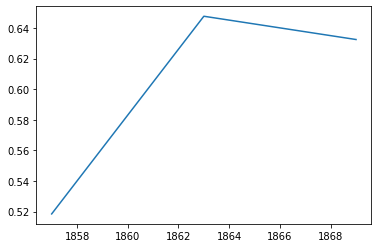

In [92]:
plt.plot(date_leg_emp2,tauxreelec_emp2)

In [93]:
tauxreelec_emp2

[0.5185185185185185, 0.6476462196861626, 0.6324404761904762]

Où on voit l'Empire qui s'embourgeoise...

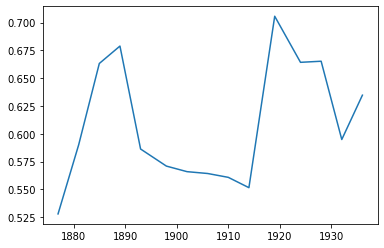

In [94]:
plt.plot(date_leg_3, tauxreelec_3)

Il semble y avoir un petit problème (mais on peut voir l'impact de l'affaire Dreyfus et de la Première Guerre Mondiale, et scandales des années 30).

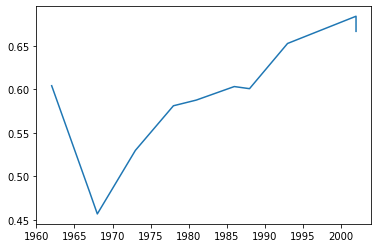

In [95]:
plt.plot(date_leg_5[:11], tauxreelec_5[:11])

On voit un effet mai 68, puis un début de professionnalisation de la politique.  

In [96]:
test=dept_naiss[dept_naiss["Département de naissance"]=="Inconnu"][dept_naiss["Régime"]=="Cinquième République"]
test.head()
y=test[["Nom","Département"]].groupby("Département").count().sort_values(by="Nom")
z=dept_naiss[["Nom","Département"]]
z=z[z["Département"].isin(y.index)]
z=z.groupby("Département").count()
z=z.join(y,on="Département",lsuffix=" en tout")
z["Pourcent"]=z["Nom"]*100/z["Nom en tout"]
print(z[z["Nom en tout"]>80][z["Pourcent"]>10].count())
z[z["Nom en tout"]>80].sort_values(by="Pourcent").tail(5)

Nom en tout    15
Nom            15
Pourcent       15
dtype: int64


C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\sylva\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Nom en tout,Nom,Pourcent
Département,,,
Yvelines,160,50,31.250000
Seine-St-Denis,145,47,32.413793
Val-de-Marne,130,48,36.923077
Essonne,89,37,41.573034
Hauts-de-Seine,178,74,41.573034


environ un député sur deux dont on connait le département de naissance s'est fait élire dans ce département

In [106]:
def pourcentageTerroir(basedep) :
    basedep_1=basedep[basedep['Département']==' '+basedep['Département de naissance']]
    nbreterroir=basedep_1[basedep_1['Département de naissance']!='Inconnu']['Département'].count()
    pourcTerroir=nbreterroir/basedep[basedep['Département de naissance']!='Inconnu']['Département'].count()
    return pourcTerroir
pourcentageTerroir(dept_naiss)

0.4818547177733789

In [116]:
regterroir=[]
for regime in reg_possible :
    regterroir+=[pourcentageTerroir(dept_naiss[dept_naiss['Régime']==regime])]

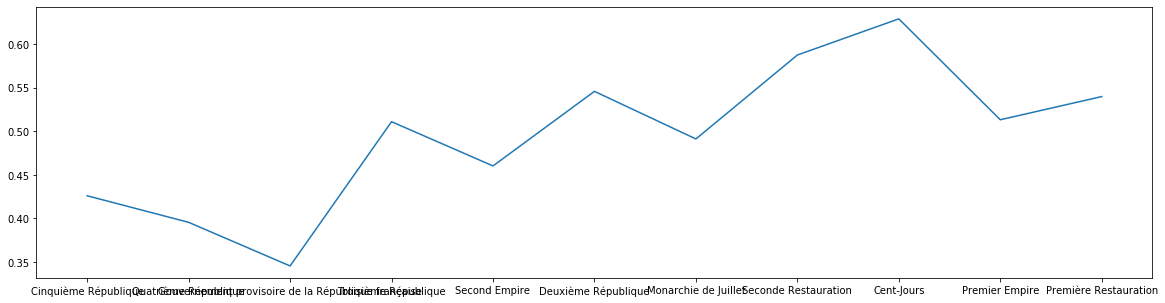

In [118]:
plt.figure(figsize=(20,5))
plt.plot(reg_possible, regterroir)

On a une tendance à la baisse, avec un taux historiquement bas lors de GPRF (où l'on avait d'autres problèmes). Cela mis à part, les deux Républiques succédant à d'autres régimes semblent faire remonter ce taux.

In [111]:
[pcterroir_3, pcterroir_5, pcterroir_emp2]=[[],[],[]]#le pourcentage de députés élus dans leur région de naissance
[date_leg_3, date_leg_5, date_leg_emp2]=[[],[],[]]
def dataparreg (basereg, pcterroir, date_leg) :
    for legislatures in range(len(listeLegislature)):
        if not basereg[basereg['Législature'] ==listeLegislature[legislatures]].empty :
            basedep=basereg[basereg['Législature'] ==listeLegislature[legislatures]]
            pcterroir+=[pourcentageTerroir(basedep)]
            date_leg+=[min(basedep.tail(1)['Date debut mandat']).year]
dataparreg(dept_naiss_3, pcterroir_3, date_leg_3)
dataparreg(dept_naiss_5, pcterroir_5, date_leg_5)
dataparreg(dept_naiss_emp2, pcterroir_emp2, date_leg_emp2)

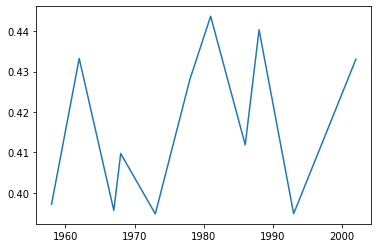

In [112]:
plt.plot(date_leg_5[:11], pcterroir_5[:11])

Pas beaucoup d'effet observable

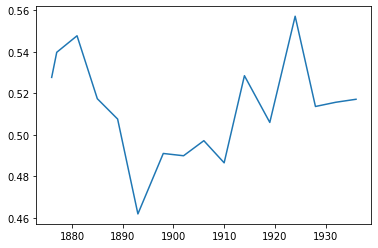

In [114]:
plt.plot(date_leg_3, pcterroir_3)

une chute au moment de l'affaire Dreyfus... Mais surtout des valeurs toujours supérieures à celles de la Cinquième République ! Les temps ont changé, l'ancrage local est devenu moins important

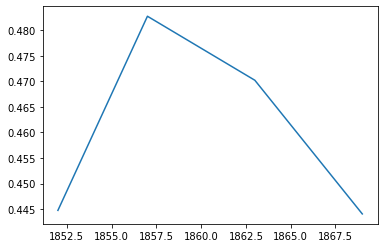

In [115]:
plt.plot(date_leg_emp2, pcterroir_emp2)

In [ ]:
Des valeurs très stables et assez faibles (plus niveau de Cinquième que de Quatrième)